In [28]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import datetime
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
from keras import layers
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate, Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, AveragePooling2D, BatchNormalization, Dropout
%matplotlib inline
import shutil
import scipy.io
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
print(os.getcwd())
for x in range(3):
    os.chdir("..")
print(os.getcwd())

e:\git\HeartResearch\Experiment\Approach\Own model approach
e:\git\HeartResearch


In [4]:
main_data_dir = os.getcwd() + "\\Data set"
print(os.listdir(main_data_dir))

['Label.csv', 'Output', 'Output.png', 'README.md', 'TrainingSet1', 'TrainingSet2', 'TrainingSet3']


In [5]:
data_mat_files = glob(main_data_dir + "/TrainingSet*/*")
print(type(data_mat_files[0]))
print(data_mat_files[0].split('\\'))

<class 'str'>
['e:', 'git', 'HeartResearch', 'Data set', 'TrainingSet1', 'A0001.mat']


In [6]:
label_path = main_data_dir + "/Label.csv"
label_df = pd.read_csv(label_path)
# label_df['First_label'].isnull().any()
print(label_df)

     Recording  First_label  Second_label  Third_label
0        A0001            5           NaN          NaN
1        A0002            1           NaN          NaN
2        A0003            2           NaN          NaN
3        A0004            2           NaN          NaN
4        A0005            7           NaN          NaN
...        ...          ...           ...          ...
6872     A6873            3           NaN          NaN
6873     A6874            8           NaN          NaN
6874     A6875            4           NaN          NaN
6875     A6876            2           NaN          NaN
6876     A6877            7           NaN          NaN

[6877 rows x 4 columns]


In [7]:
print(np.unique(label_df['First_label'].values))

[1 2 3 4 5 6 7 8 9]


In [8]:
mat = scipy.io.loadmat(data_mat_files[0])
print(mat)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Dec 19 16:06:41 2017', '__version__': '1.0', '__globals__': [], 'ECG': array([[(array(['Male'], dtype='<U4'), array([[74]], dtype=uint8), array([[ 0.0282288 ,  0.0392288 ,  0.0452288 , ...,  0.2582288 ,
         0.2592288 ,  0.2592288 ],
       [ 0.00672947,  0.01072947,  0.01472947, ...,  0.24772947,
         0.24872947,  0.24972947],
       [-0.02149933, -0.02849933, -0.03049933, ..., -0.01049933,
        -0.01049933, -0.00949933],
       ...,
       [-0.11200653, -0.11000653, -0.10800653, ...,  0.19399347,
         0.19399347,  0.19499347],
       [-0.5959572 , -0.5899572 , -0.5819572 , ...,  0.3070428 ,
         0.3070428 ,  0.3070428 ],
       [-0.01558507, -0.00658507,  0.00241493, ...,  0.21341493,
         0.21441493,  0.21441493]]))]],
      dtype=[('sex', 'O'), ('age', 'O'), ('data', 'O')])}


In [9]:
for signal in data_mat_files:
        print(type(signal))
        break

<class 'str'>


In [10]:
label_df[label_df['Recording'] == 'A0005']['First_label'].values[0]

7

In [11]:
def data_extract(signal_raw_list, label_raw, min_len = 3000):
    signal_list = []
    label_list = []
    
    for signal in signal_raw_list:
        mat = scipy.io.loadmat(signal)
        signal_list.append(mat['ECG'][0][0][2][:,:min_len])
        
        signal_number = signal.split('\\')[-1].split('.')[0]
        label_list.append(label_raw[label_raw['Recording'] == signal_number]['First_label'].values[0])
    
    le = preprocessing.LabelEncoder()
    le.fit(label_list)
    labels = le.transform(label_list)
    labels = tf.keras.utils.to_categorical(labels)
    return (np.array(signal_list), np.array(labels))

In [12]:
signal, label = data_extract(data_mat_files, label_df)

In [13]:
print(signal[0])
print(type(label))

[[ 0.0282288   0.0392288   0.0452288  ...  0.1672288   0.1762288
   0.1842288 ]
 [ 0.00672947  0.01072947  0.01472947 ...  0.20672947  0.21272947
   0.21572947]
 [-0.02149933 -0.02849933 -0.03049933 ...  0.03950067  0.03650067
   0.03150067]
 ...
 [-0.11200653 -0.11000653 -0.10800653 ...  0.33999347  0.34299347
   0.34599347]
 [-0.5959572  -0.5899572  -0.5819572  ...  0.3370428   0.3430428
   0.3460428 ]
 [-0.01558507 -0.00658507  0.00241493 ...  0.62641493  0.63141493
   0.63841493]]
<class 'numpy.ndarray'>


In [14]:
train_signal = signal[:80]
train_label = label[:80]

test_signal = signal[80:]
test_label = label[80:]

In [15]:
class Model1_LSTM(tf.keras.Model):
    def __init__(self, activation, rate, units_LSTM, units_dense, recurrent_dropout, dropout):
        super(Model1_LSTM, self).__init__()
        unit_dense1, unit_dense2 = units_dense
        act1, act2 = activation
        self.LSTM = layers.LSTM(units=units_LSTM, 
                                activation='tanh', 
                                recurrent_activation='hard_sigmoid', 
                                recurrent_dropout=recurrent_dropout,
                                dropout=dropout)
        self.dense1 = Dense(units=unit_dense1, 
                            activation=act1)
        self.drop = Dropout(rate)
        self.dense2 = Dense(units=unit_dense2,
                            activation=act2)

    def call(self, input):
        x = self.LSTM(input)
        x = self.dense1(x)
        x = self.drop(x)
        x = self.dense2(x)

        return x

In [16]:
basemodel = Model1_LSTM(units_dense = (64, 9), 
                        activation = ('relu', 'softmax'), 
                        rate = 0.5, 
                        units_LSTM= 64, 
                        recurrent_dropout= 0.2, 
                        dropout=0.2)
                        
Input = tf.keras.Input(shape= (12,3000))
# input = train_signal
output = basemodel(Input)
model = tf.keras.Model(Input, output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 3000)]        0         
                                                                 
 model1_lstm (Model1_LSTM)   (None, 9)                 789385    
                                                                 
Total params: 789,385
Trainable params: 789,385
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='adam', loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics = 'accuracy')

In [18]:
model.fit(train_signal, train_label, epochs=10, )

Epoch 1/10
3/3 [==============================] - 4s 81ms/step - loss: 2.2084 - accuracy: 0.1500
Epoch 2/10
3/3 [==============================] - 0s 77ms/step - loss: 1.9321 - accuracy: 0.4000
Epoch 3/10
3/3 [==============================] - 0s 72ms/step - loss: 1.7644 - accuracy: 0.5125
Epoch 4/10
3/3 [==============================] - 0s 70ms/step - loss: 1.5454 - accuracy: 0.6625
Epoch 5/10
3/3 [==============================] - 0s 71ms/step - loss: 1.4174 - accuracy: 0.6625
Epoch 6/10
3/3 [==============================] - 0s 70ms/step - loss: 1.2785 - accuracy: 0.8000
Epoch 7/10
3/3 [==============================] - 0s 71ms/step - loss: 1.1364 - accuracy: 0.8500
Epoch 8/10
3/3 [==============================] - 0s 71ms/step - loss: 1.0275 - accuracy: 0.8875
Epoch 9/10
3/3 [==============================] - 0s 80ms/step - loss: 0.9124 - accuracy: 0.8250
Epoch 10/10
3/3 [==============================] - 0s 72ms/step - loss: 0.8010 - accuracy: 0.9500


In [19]:
prediction = model.predict(test_signal)

In [20]:
type(prediction)

numpy.ndarray

In [21]:
prediction[0]


array([0.10871869, 0.17655358, 0.04541639, 0.04207508, 0.24635339,
       0.09159508, 0.07616662, 0.14797081, 0.06515024], dtype=float32)

In [22]:
test_label[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [23]:
print(classification_report(np.argmax(test_label,axis=1),np.argmax(prediction, axis=1)))

              precision    recall  f1-score   support

           0       0.15      0.03      0.05       907
           1       0.15      0.17      0.16      1086
           2       0.20      0.01      0.02       701
           3       0.05      0.03      0.04       202
           4       0.24      0.37      0.29      1679
           5       0.05      0.01      0.01       569
           6       0.10      0.13      0.11       645
           7       0.12      0.19      0.14       815
           8       0.06      0.13      0.08       193

    accuracy                           0.16      6797
   macro avg       0.12      0.12      0.10      6797
weighted avg       0.15      0.16      0.14      6797



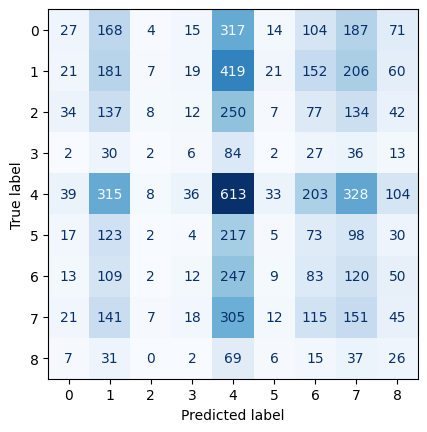

In [26]:
disp = ConfusionMatrixDisplay.from_predictions(np.argmax(test_label,axis=1),np.argmax(prediction, axis=1), colorbar=None, cmap='Blues')

In [ ]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
sns.set(font_scale=2)
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
# multi_cm = multilabel_confusion_matrix(y_true, y_pred)
cm = confusion_matrix(y_true, prediction)
df_cm = pd.DataFrame(cm, index = targetnames, columns = targetnames)
plt.figure(figsize = (15,15))
sns.heatmap(df_cm, annot=True, cmap = "Blues")